In [1]:
# Install Dependencies
import pandas as pd
import scipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Set Data Paths
mouse_metadata_path = '../data/Mouse_metadata.csv'
study_results_path = '../data/study_results.csv'

# Load Data Into Pandas
mouse_metadata_df = pd.read_csv(mouse_metadata_path)
study_results_df = pd.read_csv(study_results_path)

study_data_df = pd.merge(study_results_df, mouse_metadata_df, how='left', on='Mouse ID')

study_data_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29
3,a457,0,45.0,0,Ketapril,Female,11,30
4,c819,0,45.0,0,Ketapril,Male,21,25


In [2]:
# Get duplicate values from study data
duplicate_mouse_row = study_data_df.duplicated(subset=['Mouse ID', 'Timepoint'])
duplicate_mouse_df = study_data_df[duplicate_mouse_row]
duplicate_mouse_id_list = duplicate_mouse_df['Mouse ID'].unique()

# Drop all mice that have duplicate study rows
study_data_df = study_data_df[~study_data_df['Mouse ID'].isin(duplicate_mouse_id_list)]

## Summary Statistics

In [23]:
# Get summary statistics
drug_summary_df = study_data_df.groupby('Drug Regimen')['Tumor Volume (mm3)'].agg(
    Mean_Tumor_Volume = np.mean,
    Median_Tumor_Volume = np.median,
    Variance_Tumor_Volume = np.var,
    Stdev_Tumor_Volume = np.std,
    SEM_Tumor_Voume = stat.sem
)

# Rename columns
drug_summary_df.rename(columns={
    'Mean_Tumor_Volume': 'Mean Tumor Volume',
    'Median_Tumor_Volume': 'Median Tumor Volume',
    'Variance_Tumor_Volume': 'Tumor Volume Variance',
    'Stdev_Tumor_Volume': 'Tumor Volume Stdev',
    'SEM_Tumor_Volume': 'Tumor Volume SEM'
}, inplace = True)

drug_summary_df

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Stdev,SEM_Tumor_Voume
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

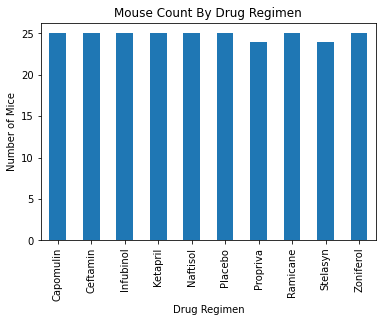

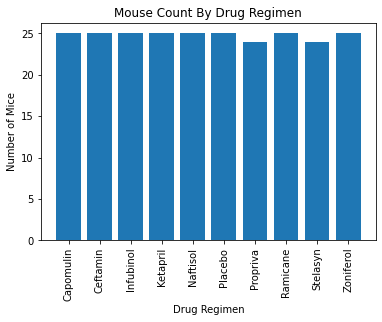

In [36]:
mice_per_trial = study_data_df.groupby('Drug Regimen')['Mouse ID'].nunique()

#plot using pandas
mice_per_trial.plot(kind='bar', rot=90, title='Mouse Count By Drug Regimen')
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Mice')
plt.show()

# plot using matplotlib
plt.bar(mice_per_trial.index, mice_per_trial)
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Mice')
plt.title('Mouse Count By Drug Regimen')
plt.xticks(rotation=90)
plt.show()

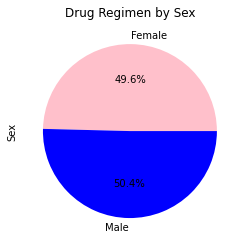

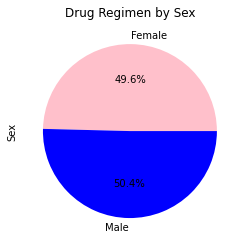

In [43]:
mice_gender = study_data_df.groupby('Sex')['Mouse ID'].nunique()

# plot using pandas
mice_gender.plot(kind = 'pie', title='Drug Regimen by Sex', autopct='%1.1f%%', colors=['pink', 'blue'])
plt.ylabel('Sex')
plt.show()

# plot using matplotlib
plt.pie(mice_gender, labels=['Female', 'Male'], autopct='%1.1f%%', colors=['pink', 'blue'])
plt.title('Drug Regimen by Sex')
plt.ylabel('Sex')
plt.show()

## Quartiles, Outliers, and Boxplots

In [54]:
filtered_drugs_df = study_data_df[study_data_df['Drug Regimen'].isin(['Capomulin', 'Ramicane, Infubinol', 'Ceftamin'])]

last_timepoint = filtered_drugs_df.groupby('Mouse ID')['Timepoint'].max()

filtered_drugs_df = filtered_drugs_df.merge(last_timepoint, how='inner', on=['Mouse ID', 'Timepoint'])
filtered_drugs_df.set_index('Mouse ID', inplace=True)
filtered_drugs_df

,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
Mouse ID,,,,,,,
u153,0,45.000000,0,Ceftamin,Female,11,25
b447,0,45.000000,0,Ceftamin,Male,2,30
x226,0,45.000000,0,Ceftamin,Male,23,28
t573,0,45.000000,0,Ceftamin,Female,15,27
h531,5,47.784682,0,Ceftamin,Male,5,27
l558,10,46.784535,0,Ceftamin,Female,13,30
w150,10,39.952347,0,Capomulin,Male,23,23
r157,15,46.539206,0,Capomulin,Male,22,25
f436,15,48.722078,2,Ceftamin,Female,3,25
